In [1]:
# import packages
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
# download data
data_dir = "data/mnist"
checkpoint_path = "checkpoint/model.ckpt"

mnist = input_data.read_data_sets(data_dir, one_hot=True)

input_size = mnist.train.images.shape[1]
label_size = mnist.train.labels.shape[1]

image_width = int(np.sqrt(input_size))
image_height = int(np.sqrt(input_size))

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


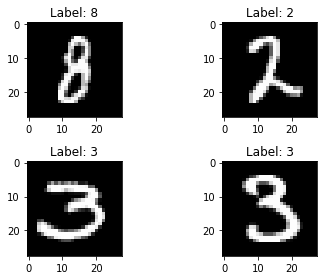

In [3]:
# visualize data
for i in range(4):
    plt.subplot(2, 2, i + 1)
    
    sample_id = np.random.randint(mnist.train.num_examples)
    label = np.argmax(mnist.train.labels[sample_id])
    plt.title("Label: {label}".format(label=label))
    plt.imshow(mnist.train.images[sample_id].reshape(image_width, image_height), cmap='gray')

plt.tight_layout()

In [4]:
def linear_model(x):
    W = tf.get_variable("W", shape=(input_size, label_size))
    b = tf.get_variable("b", shape=(label_size))
    return tf.matmul(x, W) + b

def fcn_model(x, num_hiddens):
    hidden = tf.contrib.layers.fully_connected(x, num_hiddens, activation_fn=tf.nn.relu)
    output = tf.contrib.layers.fully_connected(x, label_size, activation_fn=None)
    return output

def cnn_model(x):
    net = tf.reshape(x, (-1, image_width, image_height, 1))
    net = tf.contrib.layers.conv2d(net, 64, kernel_size=(3, 3), padding='same', activation_fn=tf.nn.relu)
    net = tf.contrib.layers.max_pool2d(net, kernel_size=(2, 2), stride=(2, 2), padding='same')
    net = tf.contrib.layers.flatten(net)
    return fcn_model(net, 32)
    
    
def loss_function(y, logits):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))

def optimizer_function(loss, learning_rate):
    return tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

def accuracy_function(y, logits):
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    return tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [5]:
learning_rate = 0.01
n_epochs = 100
batch_size = 100

tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=(None, input_size))
y = tf.placeholder(tf.float32, shape=(None, label_size))

# define model
logits = fcn_model(x, 512)
y_pred = tf.nn.softmax(logits)

# define cost function
loss = loss_function(y, logits)

# define optimizer
optimizer = optimizer_function(loss, learning_rate)

# define initializer
init = tf.global_variables_initializer()

# define accuracy
accuracy = accuracy_function(y, logits)

In [ ]:
# train
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    
    for e in range(n_epochs):
        n_batches = int(mnist.train.num_examples / batch_size)
        
        for b in range(n_batches):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            sess.run(optimizer, feed_dict={x:batch_xs, y:batch_ys})
            
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={x:mnist.test.images, y:mnist.test.labels})
        print("[Epoch {epoch}] loss = {loss}, accuracy = {acc}".format(epoch=e, loss=loss_val, acc=acc_val))
        
    saver.save(sess, checkpoint_path)

[Epoch 0] loss = 0.7586693167686462, accuracy = 0.8439000248908997
[Epoch 1] loss = 0.5721814632415771, accuracy = 0.8691999912261963
[Epoch 2] loss = 0.49797382950782776, accuracy = 0.8805999755859375
[Epoch 3] loss = 0.45692524313926697, accuracy = 0.8859999775886536
[Epoch 4] loss = 0.4303976595401764, accuracy = 0.8919000029563904
[Epoch 5] loss = 0.4104682207107544, accuracy = 0.8953999876976013
[Epoch 6] loss = 0.3961322605609894, accuracy = 0.8985999822616577
[Epoch 7] loss = 0.3844078481197357, accuracy = 0.8992000222206116
[Epoch 8] loss = 0.3748844265937805, accuracy = 0.9010000228881836
[Epoch 9] loss = 0.3671967387199402, accuracy = 0.902899980545044
[Epoch 10] loss = 0.3604971170425415, accuracy = 0.9042999744415283
[Epoch 11] loss = 0.35475096106529236, accuracy = 0.9057999849319458
[Epoch 12] loss = 0.3495735824108124, accuracy = 0.9059000015258789
[Epoch 13] loss = 0.34523171186447144, accuracy = 0.9067000150680542
[Epoch 14] loss = 0.34128907322883606, accuracy = 0.907

In [ ]:
# visualize prediction
def predict_image(image):
    with tf.Session() as sess:
        saver.restore(sess, checkpoint_path)
        return np.argmax(sess.run(y_pred, feed_dict = {x: image.reshape(1, -1)}))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    
    sample_id = np.random.randint(mnist.test.num_examples)
    image_data = mnist.test.images[sample_id]
    prediction = predict_image(image_data)
    plt.title("Predict: {prediction}".format(prediction=prediction))
    plt.imshow(image_data.reshape(image_width, image_height), cmap='gray')

plt.tight_layout()